<img src="https://www.inf.utfsm.cl/images/slides/Departamento-de-Informtica_HORIZONTAL.png" title="Title text" width="80%" />

<hr style="height:2px;border:none"/>
<h1 align='center'> Introducción al Redes Neuronales Artificiales y Deep Learning II-2024 </h1>

<H3 align='center'> Taller 2</H3>
<H4 align='center'> Equipo Mechada queso learning </H4>
<H5 align='center'> Integrantes: </H3>
<H5 align='center'>

Joanna Da Silva 

Theo Jofré

Valentina Lepin 

Felipe San Martin
</H5>

<H5 align='center'> Link video: </H3>

<hr style="height:2px;border:none"/>

## **Formalidades**  

* Equipos de trabajo de 3 personas pre-inscritos en sitio por anunciar con un nombre de fantasía que los identifique. Excepcionalmente puede haber equipos de 4 personas.

* Formato de entrega: envı́o de Jupyter notebook y entrega de video explicativo si corresponde. El desafío Kaggle puede ser entregado en un Jupyter Notebook aparte, o en un repositorio de GitHub.

* Cada persona debe estar en condiciones de realizar una presentación del trabajo realizado por su equipo y responder preguntas sobre el mismo. El día de la defensa oral serán seleccionados 4-5 presentadores aleatoriamente de entre la clase.

    * Si un integrante no se encuentra disponible en la presentación del taller y su grupo sale sorteado, se considerará como falta a evaluación. Esta es justificable con certificado médico.

## **Entregables**

* Se debe entregar el código utilizado en formato Jupyter notebook para poder **reproducir los resultados** presentados. El notebook debe estar ordenado para permitir identificar las celdas que a cada parte de la tarea y a las partes más importantes del desarrollo realizado.

* Se debe preparar un video de **5 a 10 minutos** donde se explique cómo se abordó el taller:

    - Se debe narrar brevemente la estrategia de solución adoptada enfocándose en aquello que los autores creen que la hará la solución ganadora.

    - Se descontarán 5 puntos por cada minuto excedido en el video

    - La entrega del video es **obligatorio** para la revisión para todos aquellos equipos que NO expongan en la defensa oral realizada en clases. La no entrega del video implica la no revisión del taller.
    
    - Los equipos que expongan en clases no deben de entregar este video.

# Parte 1: **Implementando una CNN (20%)**

## 0. Imports

In [1]:
import torch
from torch import nn

import numpy as np

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from tqdm.notebook import trange, tqdm

import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## 0.1. Funciones esenciales

In [2]:
def viz_imgs(imgs, labels):
  "Función para visualizar imágenes junto a sus labels"
  plt.figure(figsize=(10,10))
  random_inds = np.random.choice(imgs.shape[0],36)
  for i in range(36):
      plt.subplot(6,6,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      image_ind = random_inds[i]
      plt.imshow(np.squeeze(imgs[image_ind]), cmap=plt.cm.binary)
      plt.xlabel(labels[image_ind])

In [3]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):

    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y, y_pred.argmax(dim=1))

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [4]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y, test_pred.argmax(dim=1) )

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

## 1. Computer Vision

Durante el taller pasado, ya aprendieron lo básico de las redes neuronales y ahora nos dedicaremos a aprender arquitecturas para solucionar problemas del mundo real.

Este taller se centra en el mundo del Computer Vision, el cual es el arte de enseñarle a un computador a ver.

Puede ser tanto clasificar de forma binaria si una foto es un filete o una pizza, detectar objetos en una imagen para reconocer si se encuentran personas o autos, o incluso separar elementos de la imágenes segmentando todos los elementos en esta.

El computer vision tiene muchas áreas que abarcar.

![image.png](attachment:image.png)

Actualmente se ocupa el Computer Vision en muchas áreas:
* En la industria, se ocupa para identificar defectos en productos.
* Los autos modernos ocupan esta tecnología para evitar colisiones con seres humanos y otros autos, además para mantenerse alineado en la ruta.
* Las cámaras de seguridad permiten detectar potenciales peligros, como intrusos en zonas no permitidas.
* Las aplicaciones de fotos, como la de Google, permite clasificar las imágenes de acuerdo a personas u objetos.

### 1.1. CNN (Convolutional Neural Networks)

Existe una gran cantidad de arquitecturas para computer vision que se han ido perfeccionando a lo largo de los años.

Sin embargo, las CNN son la base de la mayoría de estos modelos más sofisticados.

Su diseño está hecho para reconocer patrones espaciales mediante el uso de kernels. Esta arquitectura se implementará en esta parte guíada y se recomienda su uso para el desafío Kaggle al ser la red más simple de implementar.

![image.png](attachment:image.png)

------------------------------------------------------

(20 puntos) Investiga y da detalles de los elementos de 5 arquitecturas para Computer Vision. Incluye imágenes de la arquitectura para clasificarla e indica las aplicaciones que tenga (por ejemplo, para Object Detection, Image Classification, Segmentation, etc)

Desarrollo:

- **Mask R-CNN** : Esta es una arquitectura que extiende Faster R-CNN para la segmentación de instancias, detectando objetos y generando máscaras a nivel de píxel. Es útil para segmentar objetos en aplicaciones como imágenes médicas o escenas complejas.
- **YOLO**: Es una arquitectura para detección de objetos que realiza predicciones en una sola pasada, lo que permite una detección rápida y precisa. Es ideal para aplicaciones en tiempo real como seguridad y vehículos autónomos.
- **YOLO V8**: YOLOv8 es una evolución de YOLO que añade segmentación de instancias, lo que permite detectar objetos y delinearlos con precisión. Se usa en aplicaciones de robótica, análisis de videos y segmentación precisa en tiempo real.
- **AlexNET**: AlexNet es una red pionera en clasificación de imágenes, conocida por ganar el desafío ImageNet en 2012. Su arquitectura profunda se usa ampliamente en aplicaciones de clasificación y reconocimiento de patrones.
- **FaceNet**: Genera vectores únicos (embeddings) que representan rostros, permitiendo compararlos para verificar identidades. Se usa en aplicaciones como el desbloqueo facial de smartphones y sistemas de seguridad por su alta precisión.

------------------------------------------------------

#### 1.1.1. Dataset a trabajar

Para ejemplificar la implementación de un problema de Computer Vision con CNN, usaremos el dataset del FashionMNIST. Este dataset contiene imágenes en blanco y negro de 10 tipos diferentes de ropa.

![image.png](attachment:image.png)

Para ello, haremos uso de la librería `torchvision.datasets` que provee Pytorch. Esta clase contiene un conjunto de dataset listos para el uso.

Se debe tener a consideración que estos datos se descargan convertidos a tensores mediante la función `ToTensor()`. Recuerden que Pytorch solo conoce los tensores.

In [5]:
# Datos de entrenamiento
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None
)

# Datos de testeo
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:17<00:00, 1481835.59it/s]


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 125090.44it/s]


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2289402.50it/s]


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



Visualicemos los datos numéricos

In [6]:
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [7]:
print(f"El tamaño de una imagen es {image.shape}. \nEsto significa que tiene 1 solo canal de color (blanco y negro), y la imagen es de 28x28 píxeles.")

El tamaño de una imagen es torch.Size([1, 28, 28]). 
Esto significa que tiene 1 solo canal de color (blanco y negro), y la imagen es de 28x28 píxeles.


Ahora visualicemos las imágenes de los primeros 32 elementos del conjunto de entrenamiento, y sus respectivos labels.

C:\Users\joann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


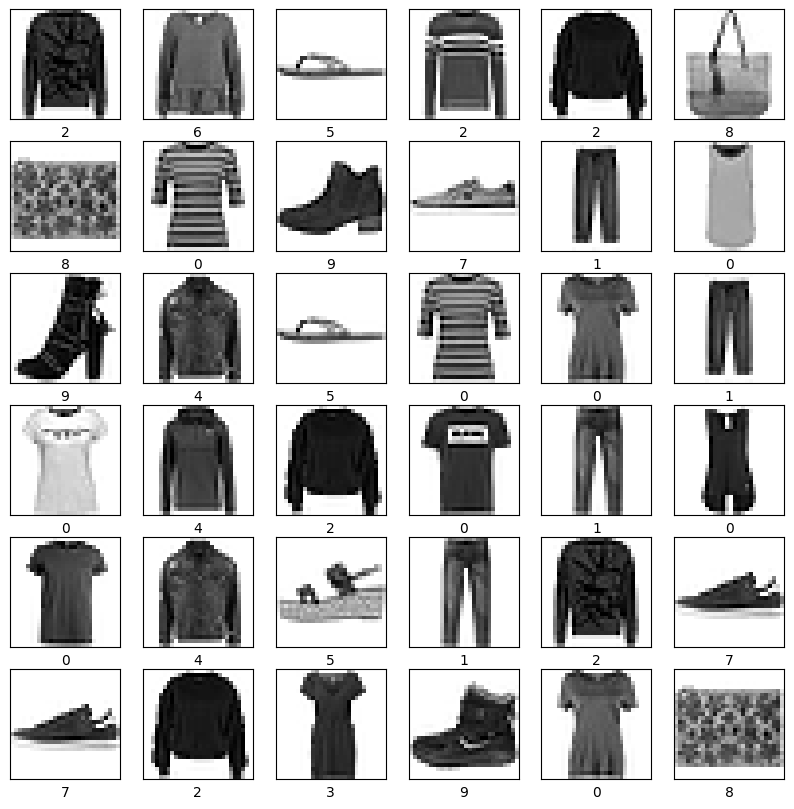

In [11]:
images = []
labels = []
for i in range(36):
    img = train_data[i][0]
    
    # Si las imágenes no tienen el mismo tamaño, podemos usar torch para redimensionarlas
    if img.shape != (28, 28):  # Aquí ajusta al tamaño esperado de las imágenes
        img = torchvision.transforms.Resize((28, 28))(img)
    
    images.append(img.numpy())  # Convertir a numpy
    labels.append(str(train_data[i][1]))

# Convertir la lista de imágenes y etiquetas a un array NumPy
images = np.array(images)
labels = np.array(labels)

viz_imgs(images, labels)

Lo bueno es que `torchvision.datasets` también provee los significados para estos labels numéricos para luego hacer el mapeo correspondiente.

In [12]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Ahora, visualicemos 36 elementos aleatorios con sus respectivos labels reales.

In [15]:
import torchvision.transforms as transforms

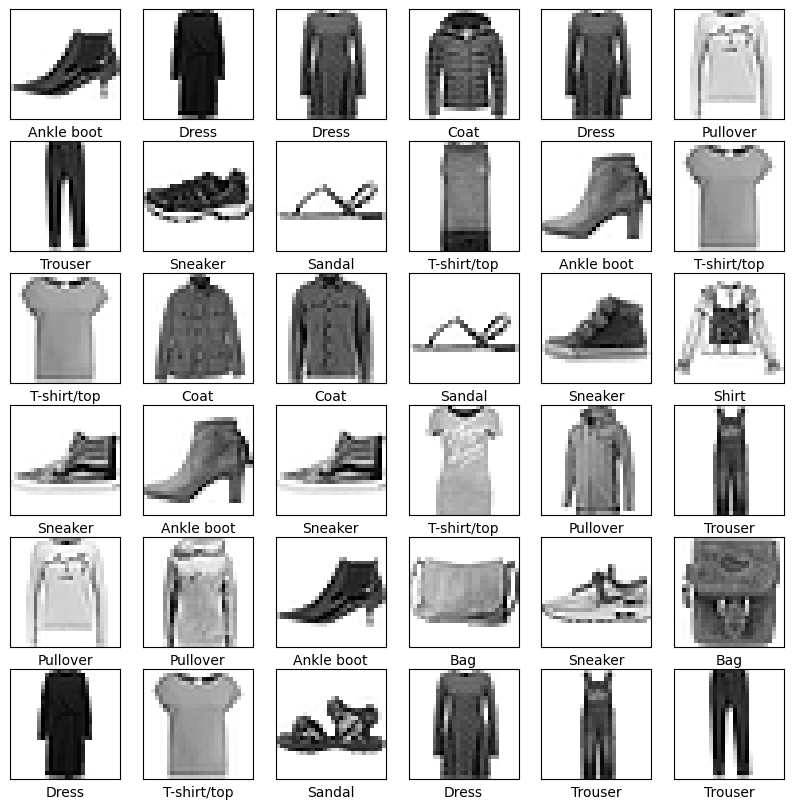

In [16]:
images = []
labels = []
resize_transform = transforms.Resize((28, 28))  # Ajusta el tamaño aquí si tus imágenes son diferentes

for i in range(36):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    
    # Redimensionar si la imagen no tiene las dimensiones deseadas
    if img.shape[-2:] != (28, 28):  # Asegúrate de que las imágenes sean de 28x28 o ajusta este tamaño
        img = resize_transform(img)
    
    images.append(img.numpy())  # Convertir imagen a numpy array
    labels.append(class_names[label])

# Convertir a arreglos NumPy
images = np.array(images)
labels = np.array(labels)

viz_imgs(images, labels)

#### 1.1.2. Creación del Dataloader

Como poseemos un dataset mucho más grande que el trabajado en el taller 1, necesitamos un Dataloader para trabajar en conjuntos de datos más pequeños o **batches** para que Google Colab (o sus computadores) no exploten con el fatídico error `Out of memory` de sus GPUs.

In [17]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Largo del train dataloader: {len(train_dataloader)} batches de {BATCH_SIZE}")
print(f"Largo del test dataloader: {len(test_dataloader)} batches de {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001EEC0CA7C50>, <torch.utils.data.dataloader.DataLoader object at 0x000001EEC0E00E10>)
Largo del train dataloader: 1875 batches de 32
Largo del test dataloader: 313 batches de 32


#### 1.1.3. Creación del modelo

Las CNN son conocidas por su capacidad de encontrar patrones en los datos no estructurados, como imágenes, videos e incluso audios y textos.

Una forma visual de entender las CNN se encuentran en [esta página](https://poloclub.github.io/cnn-explainer/) que implementa la arquitectura TinyVGG.

Una CNN sigue una estructura simple que incluye

`Input layer -> [Convolutional layer -> activation layer -> pooling layer] -> Output layer`

donde la parte `[Convolutional layer -> activation layer -> pooling layer]` puede replicarse múltiples veces.

Las capas convolucionales obtienen la información de cada imagen en base a la operación matemática realizada por el kernel, la capa de activación permite la no linealidad, y la *pooling layer* permite condensar la imagen para que retenga solo la información más importante, con lo cual se disminuye el espacio dimensional y la complejidad de las imágenes.

Más información sobre este último en [Kaggle - Maximum Pooling](https://www.kaggle.com/code/ryanholbrook/maximum-pooling)

Cada elemento convolucional 2D consiste de 3 elementos principales:

* kernel_size: Es qué tan grande es el kernel utilizado para realizar la convolución.
* stride: Es la cantidad de saltos que hace el kernel entre dos mapeos de kernel consecutivos.
* padding: Son píxeles en blanco agregados al exterior de cada imagen.

![Alt Text](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/03-conv2d-layer.gif)

In [18]:
class FashionMNISTModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*14*14,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):

        x = self.block_1(x)
        x = self.classifier(x)
        return x

torch.manual_seed(42)
model = FashionMNISTModel(input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)).to(device)
model

FashionMNISTModel(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1960, out_features=10, bias=True)
  )
)

#### 1.1.4. Seleccionar hiperparámetros

Como es clasificación multiclase, lo natural es seleccionar un CrossEntropyLoss.

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                             lr=0.1)
accuracy_fn = Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)
softmax = nn.Softmax(dim=1).to(device)

#### 1.1.5. Entrenar y testear nuestro modelo

In [20]:
torch.manual_seed(42)

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.50861 | Train accuracy: 0.82%
Test loss: 0.38088 | Test accuracy: 0.87%

Epoch: 1
---------
Train loss: 0.35354 | Train accuracy: 0.88%
Test loss: 0.34958 | Test accuracy: 0.88%

Epoch: 2
---------
Train loss: 0.31850 | Train accuracy: 0.89%
Test loss: 0.32487 | Test accuracy: 0.88%



Logró entrenar con un buena accuracy para una arquitectura simple! Ahora es su turno con el desafío Kaggle.

# Parte 2: **Desafío Kaggle (80%)**

El desafío Kaggle está en el link a continuación

https://www.kaggle.com/t/2cd29d4d82d04b5faa2b5151b1709c3d

**LEAN MUY BIEN LAS REGLAS Y TODA LA INFORMACIÓN RESPECTIVA**

# Referencias

Acá se debe incluir todas las referencias ocupadas para el desarrollo del Jupyter Notebook en formato markdown, no hay formato que se deba seguir pero cite todo. Recuerde que el plagio está castigado.

Ejemplo:

(1) [Pytorch](https://pytorch.org/)

(2) [Titanic Dataset](https://www.kaggle.com/competitions/titanic/overview)